In [1]:
## Criaçao de novas features - Modelo em Árvore

## <a id='ll'>1 Libraries</a>

In [31]:
import pandas as pd 
import numpy as np 
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
import string
import time

stop_words = list(set(stopwords.words('russian')))
punctuation = string.punctuation

# Plotting Decision tree
from sklearn import tree
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re
import pydot

## <a id='rrtd'>2 Importação dos dados</a>

In [32]:
print("Leitura......")
periods_test = pd.read_csv('data/periods_test.csv', parse_dates=["activation_date", "date_from", "date_to"], nrows=100000)
periods_train = pd.read_csv('data/periods_train.csv', parse_dates=["activation_date", "date_from", "date_to"], nrows=100000)
test = pd.read_csv('data/test.csv', nrows=100000)
train = pd.read_csv('data/train.csv', nrows=100000)
print("Ok....")
# train_active = pd.read_csv('../input/train_active.csv')
# test_active = pd.read_csv('../input/test_active.csv')

Leitura......
Ok....


In [33]:
print("train data: ", train.shape)
print("test data: ", test.shape)
print("periods_train: ", periods_train.shape)
print("periods_test: ", periods_test.shape)

train data:  (100000, 18)
test data:  (100000, 17)
periods_train:  (100000, 4)
periods_test:  (100000, 4)


## <a id='oot'>2.1 Tabelas</a>

**train data**

In [34]:
train.head(3)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177


**test data**

In [35]:
test.head(3)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,На ангарском,NaN,66,2017-04-18,Private,a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386...,2020.0
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,"Продам велосипед KAMA F200,в нормальном состо...",3000.0,4,2017-04-16,Private,NaN,NaN
2,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,Продам новый телевизор BBK 32 диагональ смарт...,15000.0,15,2017-04-17,Private,8c361112cb049745ef2d1b0ae73594fc5c107286b0c942...,2960.0


**periods train data**

In [36]:
periods_train.head(3)

,item_id,activation_date,date_from,date_to
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28


**periods test data**

In [37]:
periods_test.head(3)

,item_id,activation_date,date_from,date_to
0,f3a62a713278,2017-03-13,2017-04-12,2017-04-12
1,045ec5dabe07,2017-04-03,2017-04-12,2017-04-18
2,801d15e12e25,2017-04-17,2017-04-17,2017-04-18


# Criação de features

## Traducao para o ingles

In [38]:
## Converter Idioma colunas - ['parent_category', 'region', 'city']

parent_category_name_map = {"Личные вещи" : "Personal belongings",
                            "Для дома и дачи" : "For the home and garden",
                            "Бытовая электроника" : "Consumer electronics",
                            "Недвижимость" : "Real estate",
                            "Хобби и отдых" : "Hobbies & leisure",
                            "Транспорт" : "Transport",
                            "Услуги" : "Services",
                            "Животные" : "Animals",
                            "Для бизнеса" : "For business"}

region_map = {"Свердловская область" : "Sverdlovsk oblast",
            "Самарская область" : "Samara oblast",
            "Ростовская область" : "Rostov oblast",
            "Татарстан" : "Tatarstan",
            "Волгоградская область" : "Volgograd oblast",
            "Нижегородская область" : "Nizhny Novgorod oblast",
            "Пермский край" : "Perm Krai",
            "Оренбургская область" : "Orenburg oblast",
            "Ханты-Мансийский АО" : "Khanty-Mansi Autonomous Okrug",
            "Тюменская область" : "Tyumen oblast",
            "Башкортостан" : "Bashkortostan",
            "Краснодарский край" : "Krasnodar Krai",
            "Новосибирская область" : "Novosibirsk oblast",
            "Омская область" : "Omsk oblast",
            "Белгородская область" : "Belgorod oblast",
            "Челябинская область" : "Chelyabinsk oblast",
            "Воронежская область" : "Voronezh oblast",
            "Кемеровская область" : "Kemerovo oblast",
            "Саратовская область" : "Saratov oblast",
            "Владимирская область" : "Vladimir oblast",
            "Калининградская область" : "Kaliningrad oblast",
            "Красноярский край" : "Krasnoyarsk Krai",
            "Ярославская область" : "Yaroslavl oblast",
            "Удмуртия" : "Udmurtia",
            "Алтайский край" : "Altai Krai",
            "Иркутская область" : "Irkutsk oblast",
            "Ставропольский край" : "Stavropol Krai",
            "Тульская область" : "Tula oblast"}


category_map = {"Одежда, обувь, аксессуары":"Clothing, shoes, accessories",
"Детская одежда и обувь":"Children's clothing and shoes",
"Товары для детей и игрушки":"Children's products and toys",
"Квартиры":"Apartments",
"Телефоны":"Phones",
"Мебель и интерьер":"Furniture and interior",
"Предложение услуг":"Offer services",
"Автомобили":"Cars",
"Ремонт и строительство":"Repair and construction",
"Бытовая техника":"Appliances",
"Товары для компьютера":"Products for computer",
"Дома, дачи, коттеджи":"Houses, villas, cottages",
"Красота и здоровье":"Health and beauty",
"Аудио и видео":"Audio and video",
"Спорт и отдых":"Sports and recreation",
"Коллекционирование":"Collecting",
"Оборудование для бизнеса":"Equipment for business",
"Земельные участки":"Land",
"Часы и украшения":"Watches and jewelry",
"Книги и журналы":"Books and magazines",
"Собаки":"Dogs",
"Игры, приставки и программы":"Games, consoles and software",
"Другие животные":"Other animals",
"Велосипеды":"Bikes",
"Ноутбуки":"Laptops",
"Кошки":"Cats",
"Грузовики и спецтехника":"Trucks and buses",
"Посуда и товары для кухни":"Tableware and goods for kitchen",
"Растения":"Plants",
"Планшеты и электронные книги":"Tablets and e-books",
"Товары для животных":"Pet products",
"Комнаты":"Room",
"Фототехника":"Photo",
"Коммерческая недвижимость":"Commercial property",
"Гаражи и машиноместа":"Garages and Parking spaces",
"Музыкальные инструменты":"Musical instruments",
"Оргтехника и расходники":"Office equipment and consumables",
"Птицы":"Birds",
"Продукты питания":"Food",
"Мотоциклы и мототехника":"Motorcycles and bikes",
"Настольные компьютеры":"Desktop computers",
"Аквариум":"Aquarium",
"Охота и рыбалка":"Hunting and fishing",
"Билеты и путешествия":"Tickets and travel",
"Водный транспорт":"Water transport",
"Готовый бизнес":"Ready business",
"Недвижимость за рубежом":"Property abroad"}

In [39]:
## Convert Russian to English

## Train
train['region_english'] = train['region'].apply(lambda x : region_map[x])
train['parent_category_name_english'] = train['parent_category_name'].apply(lambda x : parent_category_name_map[x])
train['category_name_english'] = train['category_name'].apply(lambda x : category_map[x])

## Test
test['region_english'] = train['region'].apply(lambda x : region_map[x])
test['parent_category_name_english'] = test['parent_category_name'].apply(lambda x : parent_category_name_map[x])
test['category_name_english'] = test['category_name'].apply(lambda x : category_map[x])


In [40]:
## Combinar as features Param 1, 2 e 3 

# param_combined and its length
train['param_combined'] = train.apply(lambda row: ' '.join([str(row['param_1']), str(row['param_2']),  str(row['param_3'])]), axis=1)
train['param_combined'] = train['param_combined'].fillna(" ")
train['param_combined_len'] = train['param_combined'].apply(lambda x : len(x.split()))

# Test
test['param_combined'] = test.apply(lambda row: ' '.join([str(row['param_1']), str(row['param_2']),  str(row['param_3'])]), axis=1)
test['param_combined'] = test['param_combined'].fillna(" ")
test['param_combined_len'] = test['param_combined'].apply(lambda x : len(x.split()))

## Serie temporal 

**Novas features a partir da activation_date :**

 - month
 - weekday
 - month_day
 - year_day

In [41]:
train['activation_date'] = pd.to_datetime(train['activation_date'])
test['activation_date'] = pd.to_datetime(test['activation_date'])

# Train data
train["month"] = train["activation_date"].dt.month
train['weekday'] = train['activation_date'].dt.weekday
train["day"] = train['activation_date'].dt.day
train["year_Day"] = train['activation_date'].dt.dayofyear

#Test data
test["month"] = test["activation_date"].dt.month
test['weekday'] = test['activation_date'].dt.weekday
test["day"] = test['activation_date'].dt.day
test["year_Day"] = test['activation_date'].dt.dayofyear 

## Fill NaN
train["description"].fillna("NA", inplace=True)
test["description"].fillna("NA", inplace=True)

# periods_train
periods_train['total_period'] = periods_train['date_to'] - periods_train['date_from']
periods_test['total_period'] = periods_train['date_to'] - periods_train['date_from']

periods_train['total_days'] = periods_train['date_to'] - periods_train['date_from']
periods_test['total_days'] = periods_test['date_to'] - periods_test['date_from']
periods_train['total_days_value'] = periods_train['total_days'].dt.days
periods_test['total_days_value'] = periods_test['total_days'].dt.days

## Descriçao e titulo

Criar novas features :
* **char_count**
* **word_count**
* **word_density**
* **punctuation_count**
* **title_word_count**
* **upper_case_word_count**
* **stopword_count**

In [42]:
start_time=time.time()

# Train data
#train['d_length'] = train['description'].apply(lambda x: len(str(x))) 
train["description"].fillna("NA", inplace=True)
train['char_count'] = train['description'].apply(len)
train['word_count'] = train['description'].apply(lambda x: len(x.split()))
train['word_density'] = train['char_count'] / (train['word_count']+1)
train['punctuation_count'] = train['description'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
train['title_word_count'] = train['description'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
train['upper_case_word_count'] = train['description'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
train['stopword_count'] = train['description'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))

# Test data
#test['d_length'] = test['description'].apply(lambda x: len(str(x))) 
test["description"].fillna("NA", inplace=True)
test['char_count'] = test['description'].apply(len)
test['word_count'] = test['description'].apply(lambda x: len(x.split()))
test['word_density'] = test['char_count'] / (test['word_count']+1)
test['punctuation_count'] = test['description'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
test['title_word_count'] = test['description'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
test['upper_case_word_count'] = test['description'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
test['stopword_count'] = test['description'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))

end_time=time.time()
print("total time in the cuurent cell ",end_time-start_time,"s")

total time in the cuurent cell  11.6974196434021 s


## Variáveis categoricas para numéricas

   - region
   - city
   - parent_category_name
   - category_name
   - user_type
   - param_1
   - param_2
   - param_3

In [43]:
# Label encode the categorical variables
cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
for col in cat_vars:
    lb = preprocessing.LabelEncoder()
    lb.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lb.transform(list(train[col].values.astype('str')))
    test[col] = lb.transform(list(test[col].values.astype('str')))

## Remover features não utilizadas

- item_id
- user_id
- title
- description
- activation_date
- image
- region_en
- parent_category_name_en
- category_name_en
- deal_probability

In [44]:
## Drop NA
train.dropna(inplace=True)
test.dropna(inplace=True)

cols_to_drop = ["item_id", "user_id", "title", "description", "activation_date", "image", 'param_combined']

## Dataset para o Modelo
train_df = train.drop(cols_to_drop + ["region_english", "parent_category_name_english", "category_name_english"], axis=1)
test_df = test.drop(cols_to_drop + ["region_english", "parent_category_name_english", "category_name_english"], axis=1)

In [45]:
test

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,weekday,day,year_Day,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count
2,8bab230b2ecd,0b850bbebb10,12,128,0,2,301,80,734,BBK,...,0,17,107,132,21,6.000000,1,2,2,4
4,8bd2fe400b89,23e2d97bfc7f,14,204,4,42,92,80,734,Коляска зима-лето,...,5,15,105,60,10,5.454545,4,1,0,2
5,c63dbd6c657f,c2a632af2602,16,1043,2,38,210,80,734,Стекла для пластиковых окон,...,2,12,102,222,28,7.655172,25,1,0,0
6,6d1a410df86e,b239811ad530,14,909,0,27,31,80,734,Ноутбук Lenovo Ideapad 300-15Ibr арт.14899,...,0,17,107,1745,220,7.895928,189,42,11,25
7,e8d3e7922b80,d85fa02e6341,7,474,0,41,40,231,734,Nillkin Phenom для Apple iPhone,...,1,18,108,742,111,6.625000,60,17,10,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,0d50bd1ca892,ecfec4dafce1,20,1144,3,20,341,80,734,Шотландские,...,6,16,106,9,1,4.500000,0,1,0,0
99995,980139d2e3ce,0f9042a68a25,24,437,4,29,191,95,115,Анарак skills (утеплёный),...,0,17,107,146,17,8.111111,6,2,0,3
99996,6b3f403b130f,0e5788c15a1c,5,271,2,33,307,80,734,Продается фляга алюминиевая 40 л,...,4,14,104,114,17,6.333333,7,2,0,4
99997,9fd3cfcdaa99,77df1b18f8f9,18,1066,4,10,100,89,150,Galliano и Franki Morello,...,4,14,104,68,12,5.230769,3,3,0,3


# Feature importance - Gradient Boosting

In [46]:
# Target and ID variables 
yt = train["deal_probability"].values
test_id = test["item_id"].values

In [47]:
start_time=time.time()

t_df = train_df.drop(['deal_probability'], axis=1)

t_df.fillna(-1, inplace = True)
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
gb.fit(t_df, yt)
features = t_df.columns.values

end_time=time.time()
print("total time in the cuurent cell ",end_time-start_time,"s")

total time in the cuurent cell  19.171719789505005 s


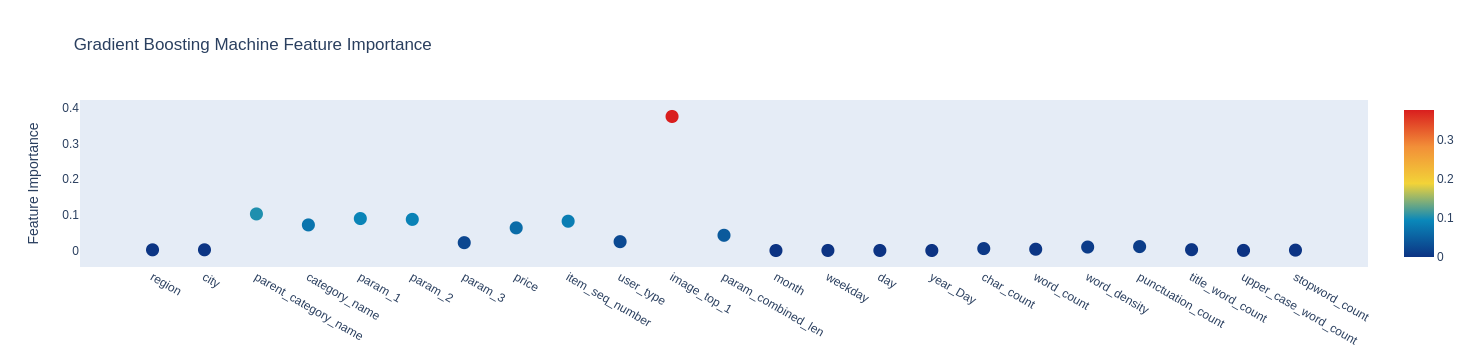

In [48]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [49]:
train_df.head(3)

,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,item_seq_number,user_type,...,weekday,day,year_Day,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count
0,19,365,4,42,232,80,734,400.0,2,1,...,1,28,87,58,7,7.250,2,1,0,1
1,17,1061,2,22,112,80,734,3000.0,19,1,...,6,26,85,41,7,5.125,3,2,1,3
2,16,1043,0,2,74,80,734,4000.0,9,1,...,0,20,79,99,17,5.500,5,3,2,4


In [50]:
test_df.head(3)

,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,item_seq_number,user_type,...,weekday,day,year_Day,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count
2,12,128,0,2,301,80,734,15000.0,15,1,...,0,17,107,132,21,6.000000,1,2,2,4
4,14,204,4,42,92,80,734,4900.0,15,1,...,5,15,105,60,10,5.454545,4,1,0,2
5,16,1043,2,38,210,80,734,500.0,39,1,...,2,12,102,222,28,7.655172,25,1,0,0


# Model - Decision Tree 

In [51]:
from sklearn.model_selection import train_test_split

x = train_df.drop(['deal_probability'], axis=1)
y = train_df['deal_probability'].values

print(x.shape)
print(y.shape)

(88519, 23)
(88519,)


In [52]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(59307, 23)
(59307,)
(29212, 23)
(29212,)


In [53]:
from sklearn.tree import DecisionTreeRegressor

# mean squered error == varince as spliting criteria and set the minimum number
regression_model = DecisionTreeRegressor(criterion="mse") 

#Fit the model
regression_model.fit(x_train, y_train)

DecisionTreeRegressor()

In [54]:
#Predict unseen query instances
predicted = regression_model.predict(x_test)

#Compute and plot the RMSE
RMSE = np.sqrt(np.sum(((y_test-predicted)**2)/len(y_test)))
RMSE

0.3373282818808491

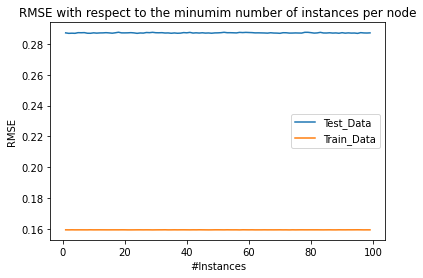

In [55]:
"""
Plot the RMSE with respect to the minimum number of instances
""" 
fig = plt.figure()
ax0 = fig.add_subplot(111) 

RMSE_train = []
RMSE_test = []

for i in range(1,100):
    #Paramterize the model and let i be the number of minimum instances per leaf node
    regression_model = DecisionTreeRegressor(criterion="mse",min_samples_leaf=5)   
    #Train the model
    regression_model.fit(x_train, y_train)
    #Predict query instances
    predicted_train = regression_model.predict(x_train)
    predicted_test = regression_model.predict(x_test)
    #Calculate and append the RMSEs
    RMSE_train.append(np.sqrt(np.sum(((y_train-predicted_train)**2)/len(y_train))))
    RMSE_test.append(np.sqrt(np.sum(((y_test-predicted_test)**2)/len(y_test))))


   
ax0.plot(range(1,100),RMSE_test,label='Test_Data')
ax0.plot(range(1,100),RMSE_train,label='Train_Data')
ax0.legend()
ax0.set_title('RMSE with respect to the minumim number of instances per node')
ax0.set_xlabel('#Instances')
ax0.set_ylabel('RMSE')
plt.show()

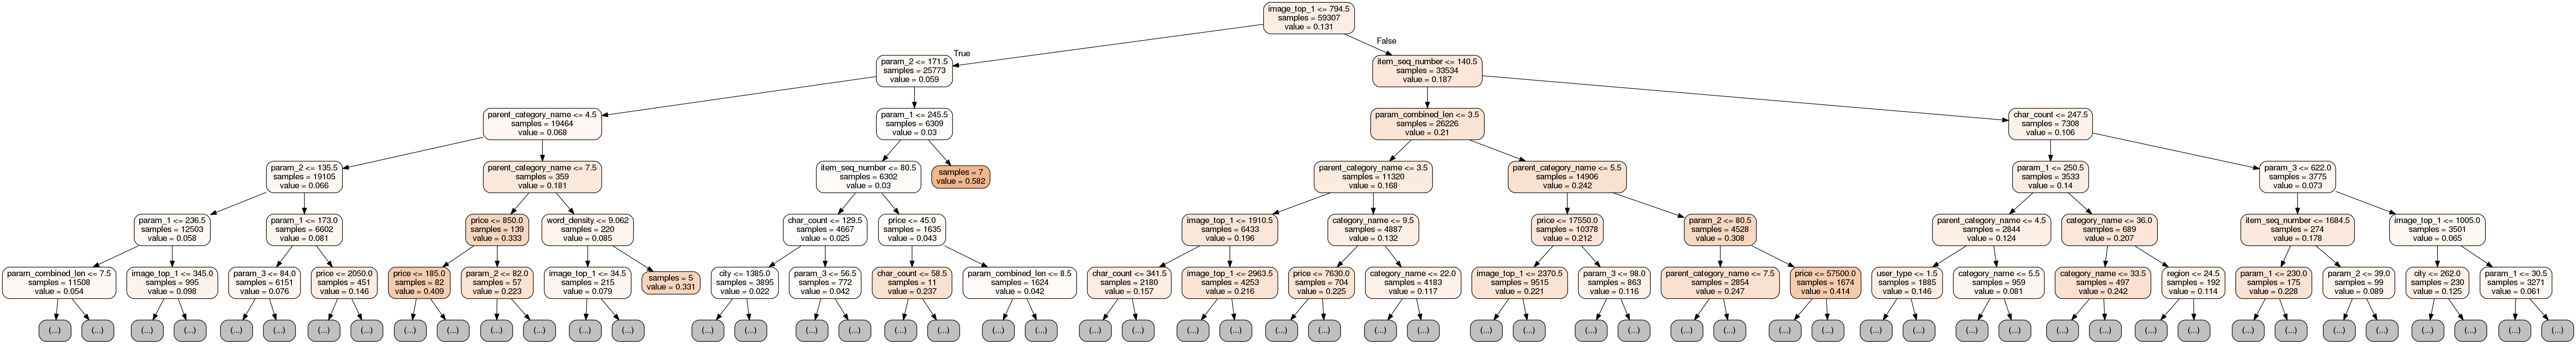

In [56]:
## Visualizar arvore

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(regression_model,
                              out_file=f,
                              max_depth = 5,
                              impurity = False,
                              feature_names = x_train.columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
(graph,) = pydot.graph_from_dot_file('tree1.dot')
graph.write_png('tree1.png')

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)

### Model 2

In [28]:
decision_tree = tree.DecisionTreeRegressor(criterion="mse", max_depth = 5)
regressor = decision_tree.fit(train_df, yt)

In [29]:
cross_val_score(regressor, train_df, yt, cv=10)

array([0.99960853, 0.99963602, 0.9996172 , 0.99962266, 0.99962834,
       0.9996091 , 0.99961408, 0.99964199, 0.99960509, 0.99963273])

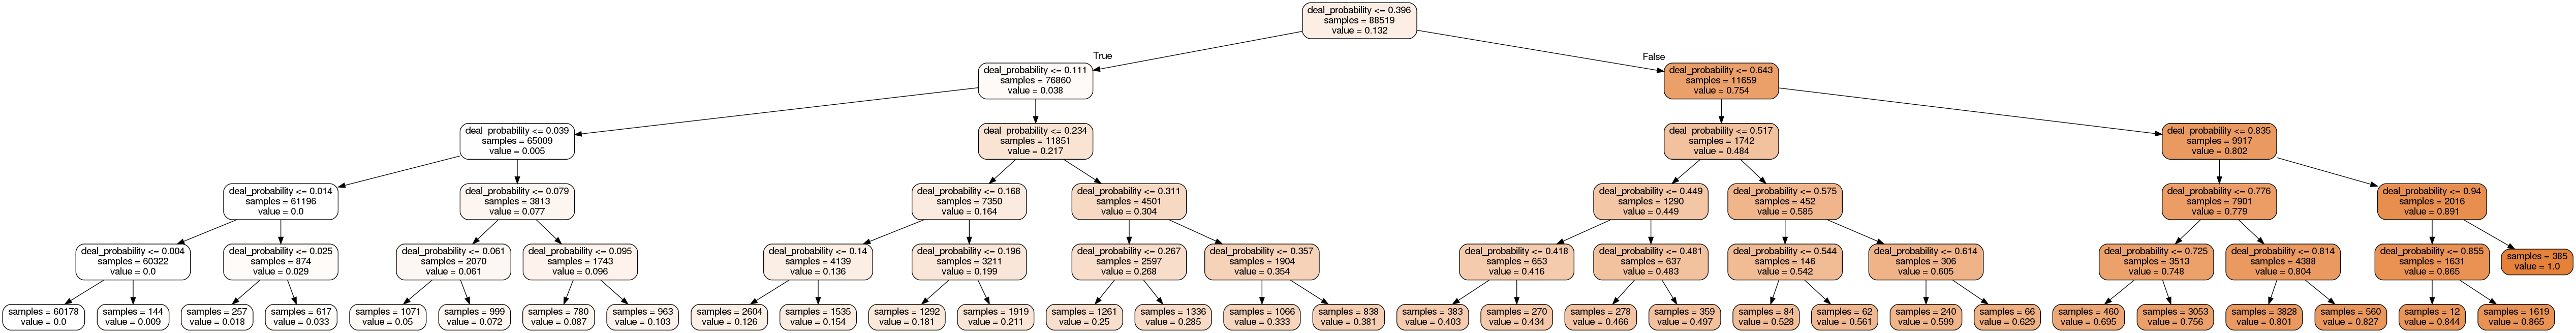

In [30]:
## Visualizar arvore

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 8,
                              impurity = False,
                              feature_names = train_df.columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
(graph,) = pydot.graph_from_dot_file('tree1.dot')
graph.write_png('tree1.png')

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)